In [1]:
import cv2
import os
import random
import torch
# print("CUDA Available:", torch.cuda.is_available())  # Should return True
# print("CUDA Device Count:", torch.cuda.device_count())  # Should be >0
# print("GPU Name:", torch.cuda.get_device_name(0))  # Your GPU model

In [ ]:
def extract_frames(video_folder, output_train_folder, output_test_folder, fps=10, test_ratio=0.2):
    """ 
    Extract frames from videos.
    - Training: All frames in a **single folder**, named sequentially (`frame_00000.jpg`, `frame_00001.jpg`, etc.).
    - Testing: Each video has its **own folder**, frames named sequentially (`frame_00000.jpg`, `frame_00001.jpg`, etc.).
    """
    os.makedirs(output_train_folder, exist_ok=True)
    os.makedirs(output_test_folder, exist_ok=True)

    videos = [f for f in os.listdir(video_folder) if f.endswith('.mp4')]
    random.shuffle(videos)  # Shuffle videos for randomness
    test_count = int(len(videos) * test_ratio)

    test_videos = videos[:test_count]  #20% for testing (separate folders)
    train_videos = videos[test_count:]  #80% for training (one folder)

    global_frame_count = 0  #Keep track of the total frame number for training

    def process_training(video_list, output_folder):
        nonlocal global_frame_count
        for video in video_list:
            video_path = os.path.join(video_folder, video)

            cap = cv2.VideoCapture(video_path)
            frame_rate = cap.get(cv2.CAP_PROP_FPS)
            frame_interval = max(1, int(frame_rate / fps))
            frame_count = 0

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                if frame_count % frame_interval == 0:
                    frame_name = os.path.join(output_folder, f"frame_{global_frame_count:05d}.jpg")
                    cv2.imwrite(frame_name, frame)
                    global_frame_count += 1
                frame_count += 1

            cap.release()
            print(f"Training frames extracted from {video} into {output_folder}")

    def process_testing(video_list, output_folder):
        for video in video_list:
            video_path = os.path.join(video_folder, video)
            video_name = os.path.splitext(video)[0]
            video_output_folder = os.path.join(output_folder, video_name)
            os.makedirs(video_output_folder, exist_ok=True)

            cap = cv2.VideoCapture(video_path)
            frame_rate = cap.get(cv2.CAP_PROP_FPS)
            frame_interval = max(1, int(frame_rate / fps))
            frame_count = 0
            saved_frame_count = 0

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                if frame_count % frame_interval == 0:
                    frame_name = os.path.join(video_output_folder, f"frame_{saved_frame_count:05d}.jpg")
                    cv2.imwrite(frame_name, frame)
                    saved_frame_count += 1
                frame_count += 1

            cap.release()
            print(f"Testing frames extracted from {video} into {video_output_folder}")

    # Process training videos (all frames go into a single folder with global numbering)
    process_training(train_videos, output_train_folder)

    # Process testing videos (each video gets its own folder)
    process_testing(test_videos, output_test_folder)

# Extract frames for DPI videos (80% training, 20% testing)
extract_frames("../dpi-videos", "frames/dpi-train", "frames/dpi-test", fps=10)

# Extract frames for OPI videos (80% training, 20% testing)
extract_frames("../opi-videos", "frames/opi-train", "frames/opi-test", fps=10)


Training frames extracted from Untitled video - Made with Clipchamp (33).mp4 into frames/dpi-train
Training frames extracted from Untitled video - Made with Clipchamp (18).mp4 into frames/dpi-train
Training frames extracted from Untitled video - Made with Clipchamp (31).mp4 into frames/dpi-train
Training frames extracted from Untitled video - Made with Clipchamp (11).mp4 into frames/dpi-train
Training frames extracted from Untitled video - Made with Clipchamp (30).mp4 into frames/dpi-train
Training frames extracted from Untitled video - Made with Clipchamp (22).mp4 into frames/dpi-train
Training frames extracted from Untitled video - Made with Clipchamp (4).mp4 into frames/dpi-train
Training frames extracted from Untitled video - Made with Clipchamp (9).mp4 into frames/dpi-train
Training frames extracted from Untitled video - Made with Clipchamp (12).mp4 into frames/dpi-train
Training frames extracted from Untitled video - Made with Clipchamp (28).mp4 into frames/dpi-train
Training fra

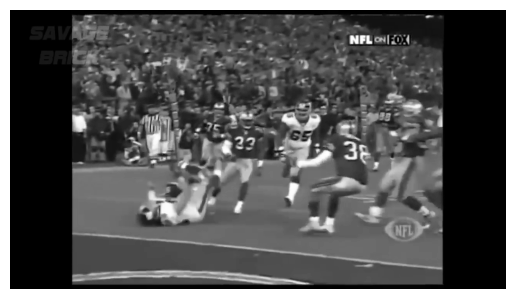

In [ ]:
# #Grey Scale Conversion, not necessarily used for now
# image_path = "frame_00022.jpg"  # Replace with your image path
# image = cv2.imread(image_path)

# if image is None:
#     print("Error: Image not found. Check the path!")
# else:
#     # Convert to grayscale
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # Save the grayscale image
#     cv2.imwrite("output_bw.jpg", gray_image)

#     # Display using matplotlib (since cv2.imshow() doesn't work well in Jupyter)
#     import matplotlib.pyplot as plt
#     plt.imshow(gray_image, cmap='gray')
#     plt.axis('off')
#     plt.show()

In [4]:
import os
import shutil

# Define dataset paths
images_dir = "frames/dpi-train"   # Path to all images
labels_dir = "frames/dpi-label-1"   # Path to labels
output_dir = "frames/labelled-frames"  # Destination for filtered images

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Copy only images that have corresponding labels
copied_count = 0
for label_file in os.listdir(labels_dir):
    if label_file.endswith(".txt"):
        image_file = label_file.replace(".txt", ".jpg")  # Adjust if images have a different extension
        image_path = os.path.join(images_dir, image_file)
        if os.path.exists(image_path):  # Ensure image exists
            shutil.copy(image_path, os.path.join(output_dir, image_file))  # Copy file
            copied_count += 1

print(f"✅ Copied {copied_count} labeled frames to {output_dir}.")


✅ Copied 16 labeled frames to frames/labelled-frames.


In [3]:
from ultralytics import YOLO

# Load trained model
model = YOLO(r"E:\Hacklytics-2025\hacklytics-2025\frames\runs\detect\train\weights\best.pt")

# Path to the test image
image_path = r"E:\Hacklytics-2025\hacklytics-2025\frame_01367.jpg"

# Run inference
results = model(image_path, device="cuda", save=False)

# Check if any objects were detected
if len(results[0].boxes) == 0:
    print("❌ No objects detected!")
else:
    print("✅ Detected Objects:")
    for box in results[0].boxes:
        class_id = int(box.cls[0])  # Class ID
        class_name = model.names[class_id]  # Get class name
        conf = box.conf[0]  # Confidence score
        print(f" - {class_name} ({conf:.2f} confidence)")



image 1/1 E:\Hacklytics-2025\hacklytics-2025\frame_01367.jpg: 384x640 (no detections), 41.6ms
Speed: 1.5ms preprocess, 41.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
❌ No objects detected!


In [5]:
import os
from ultralytics import YOLO

# Load trained YOLO model (from Step 2)
model = YOLO(r"E:\Hacklytics-2025\hacklytics-2025\frames\runs\detect\train\weights\best.pt")

# Directory with unlabeled frames
frames_dir = r"E:\Hacklytics-2025\hacklytics-2025\frames\dpi-train"
output_labels_dir = r"E:\Hacklytics-2025\hacklytics-2025\frames\auto-labels"

# Ensure output directory exists
os.makedirs(output_labels_dir, exist_ok=True)

# Iterate through all images in the unlabeled folder
image_files = [f for f in os.listdir(frames_dir) if f.endswith((".jpg", ".png"))]

for image_file in image_files:
    image_path = os.path.join(frames_dir, image_file)
    results = model(image_path, device="cuda", save=False)

    # Generate YOLO label file
    label_file = os.path.join(output_labels_dir, image_file.replace(".jpg", ".txt").replace(".png", ".txt"))

    with open(label_file, "w") as f:
        for box in results[0].boxes:
            class_id = int(box.cls[0])  # Class ID
            x_center, y_center, width, height = box.xywhn[0]  # YOLO normalized format
            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

    print(f"✅ Auto-labeled {image_file} -> {label_file}")

print("\n🔥 Auto-labeling completed! Review generated labels before training.")



image 1/1 E:\Hacklytics-2025\hacklytics-2025\frames\dpi-train\frame_00000.jpg: 384x640 6 balls, 40.4ms
Speed: 1.7ms preprocess, 40.4ms inference, 49.2ms postprocess per image at shape (1, 3, 384, 640)
✅ Auto-labeled frame_00000.jpg -> E:\Hacklytics-2025\hacklytics-2025\frames\auto-labels\frame_00000.txt

image 1/1 E:\Hacklytics-2025\hacklytics-2025\frames\dpi-train\frame_00001.jpg: 384x640 4 balls, 25.4ms
Speed: 1.8ms preprocess, 25.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
✅ Auto-labeled frame_00001.jpg -> E:\Hacklytics-2025\hacklytics-2025\frames\auto-labels\frame_00001.txt

image 1/1 E:\Hacklytics-2025\hacklytics-2025\frames\dpi-train\frame_00002.jpg: 384x640 5 balls, 25.4ms
Speed: 1.5ms preprocess, 25.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
✅ Auto-labeled frame_00002.jpg -> E:\Hacklytics-2025\hacklytics-2025\frames\auto-labels\frame_00002.txt

image 1/1 E:\Hacklytics-2025\hacklytics-2025\frames\dpi-train\frame_00003.jpg: 384x